In [1]:


import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## Exploratory Data Analysis on Uber Request data

## Data Cleaning


In [2]:
#Reading Uber Request data
uberReq = pd.read_csv('../input/Uber Request Data.csv',encoding = "ISO-8859-1")
uberReq.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [3]:
#Correcting the data types
uberReq['Request timestamp'] = pd.to_datetime(uberReq['Request timestamp'])
uberReq['Drop timestamp'] = pd.to_datetime(uberReq['Drop timestamp'])
uberReq.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47


In [4]:
# Removing unnecessary columns
uberReq = uberReq.drop(['Driver id'], axis = 1)

In [5]:
uberReq.tail()

,Request id,Pickup point,Status,Request timestamp,Drop timestamp
6740,6745,City,No Cars Available,2016-07-15 23:49:03,NaT
6741,6752,Airport,No Cars Available,2016-07-15 23:50:05,NaT
6742,6751,City,No Cars Available,2016-07-15 23:52:06,NaT
6743,6754,City,No Cars Available,2016-07-15 23:54:39,NaT
6744,6753,Airport,No Cars Available,2016-07-15 23:55:03,NaT


In [6]:
print(uberReq['Pickup point'].unique())

['Airport' 'City']


In [7]:
uberReq.shape

(6745, 5)

In [8]:
uberReq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 5 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Status               6745 non-null object
Request timestamp    6745 non-null datetime64[ns]
Drop timestamp       2831 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 263.6+ KB


In [9]:
uberReq.isnull().sum(axis=0)

Request id              0
Pickup point            0
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

In [10]:
uberReq[(uberReq['Drop timestamp'].isnull())].groupby('Status').size()

Status
Cancelled            1264
No Cars Available    2650
dtype: int64

In [11]:
print(len(uberReq['Request id'].unique()))
print(len(uberReq['Pickup point'].unique()))
print(len(uberReq['Status'].unique()))

6745
2
3


In [12]:
len(uberReq[uberReq.duplicated()].index)

0

## Univariate Analysis

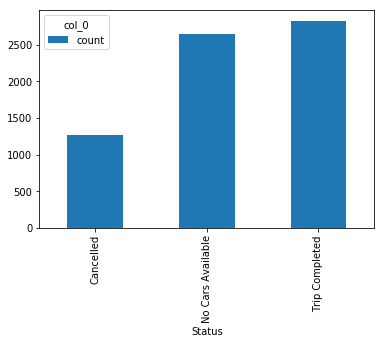

In [13]:
#Univariate analysis on Status column 
status = pd.crosstab(index = uberReq["Status"], columns="count")     
status.plot.bar()



`No cars available` is more than the number of trips `cancelled`. 

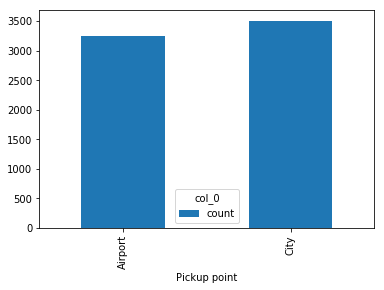

In [14]:
#Univariate analysis on Pickup Point column 
pick_point = pd.crosstab(index = uberReq["Pickup point"], columns="count")     
pick_point.plot.bar()



The pickup points `Airport` and `City` are almost equal times present in the dataset.

## Bivariate Analysis

In [15]:
#grouping by Status and Pickup point.
uberReq.groupby(['Status', 'Pickup point']).size()

Status             Pickup point
Cancelled          Airport          198
                   City            1066
No Cars Available  Airport         1713
                   City             937
Trip Completed     Airport         1327
                   City            1504
dtype: int64

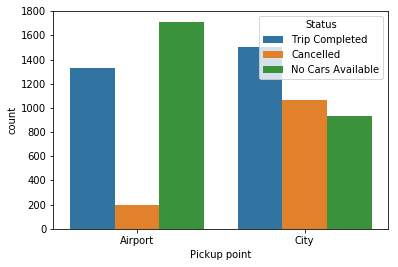

In [16]:
# Visualizing the count of Status and Pickup point bivariate analysis
sns.countplot(x=uberReq['Pickup point'],hue =uberReq['Status'] ,data = uberReq)

#### Bivariate Analysis conclusion of Status and Pickup point columns:

- There are more `No cars available` from `Airport` to `City`.
- There are more cars `Cancelled` from `City` to `Airport`.

## Deriving new metrics

In [17]:
#Request and Drop hours
uberReq['Request Hour'] = uberReq['Request timestamp'].dt.hour

In [18]:
#Time Slots
uberReq['Request Time Slot'] = 'Early Morning'
uberReq.loc[uberReq['Request Hour'].between(5,8, inclusive=True),'Request Time Slot'] = 'Morning'
uberReq.loc[uberReq['Request Hour'].between(9,12, inclusive=True),'Request Time Slot'] = 'Late Morning'
uberReq.loc[uberReq['Request Hour'].between(13,16, inclusive=True),'Request Time Slot'] = 'Noon'
uberReq.loc[uberReq['Request Hour'].between(17,21, inclusive=True),'Request Time Slot'] = 'Evening'
uberReq.loc[uberReq['Request Hour'].between(21,24, inclusive=True),'Request Time Slot'] = 'Night'

In [19]:
#As Demand can include trips completed, cancelled or no cars available, we will create a column with 1 as a value
uberReq['Demand'] = 1

In [20]:
#As Supply can only be the trips completed, rest all are excluded, so we will create a column with 1 as a supply value trips completed and 0 otherwise.
uberReq['Supply'] = 0
uberReq.loc[(uberReq['Status'] == 'Trip Completed'),'Supply'] = 1

In [21]:
#Demand Supply Gap can be defined as a difference between Demand and Supply
uberReq['Gap'] = uberReq['Demand'] - uberReq['Supply']
uberReq.loc[uberReq['Gap']==0,'Gap'] = 'Trip Completed'
uberReq.loc[uberReq['Gap']==1,'Gap'] = 'Trip Not Completed'

In [22]:
#Removing unnecessary columns
uberReq = uberReq.drop(['Request Hour', 'Demand', 'Supply'], axis=1)

In [23]:
uberReq.head()

,Request id,Pickup point,Status,Request timestamp,Drop timestamp,Request Time Slot,Gap
0,619,Airport,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,Late Morning,Trip Completed
1,867,Airport,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,Evening,Trip Completed
2,1807,City,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,Late Morning,Trip Completed
3,2532,Airport,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,Night,Trip Completed
4,3112,City,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,Morning,Trip Completed


## Graphical Analysis

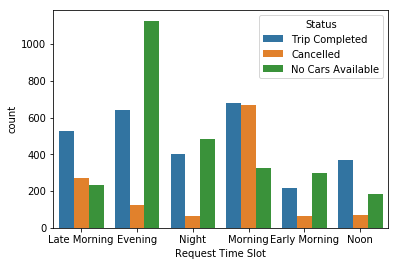

In [24]:
# Plot to find the count of the three requests, according to the defined time slots
sns.countplot(x=uberReq['Request Time Slot'],hue =uberReq['Status'] ,data = uberReq)

#### Conclusions from above plot :

- Most `No Cars Available` are in the `Evening`.
- Most `Cancelled` trips are in the `Morning`.

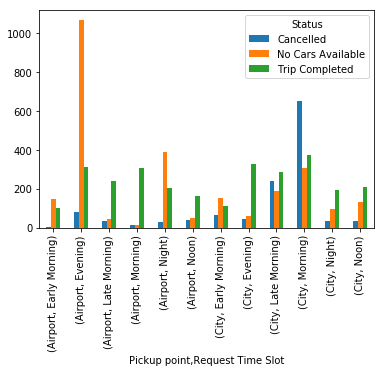

In [25]:
# Plot to find the count of the status, according to both pickup point and the time slot
pickup_df = pd.DataFrame(uberReq.groupby(['Pickup point','Request Time Slot', 'Status'])['Request id'].count().unstack(fill_value=0))
pickup_df.plot.bar()

#### Conclusions from above plot :

- Most `No Cars Available` are in the `Evening` from `Airport` to `City`.
- Most `Cancelled` trips are in the `Morning` from `City` to `Airport`.

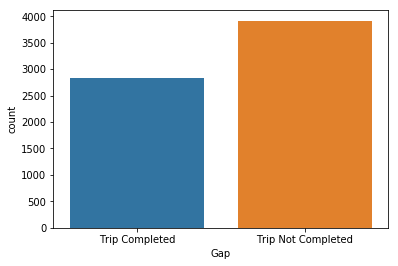

In [26]:
#Plot to count the number of requests that was completed and which was not
sns.countplot(x=uberReq['Gap'], data = uberReq)

#### Conclusions from above plot :

More `Trip not completed` than `Trip Completed`.

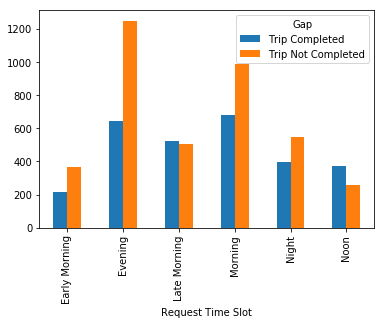

In [27]:
##Plot to count the number of requests that was completed and which was not, against the time slot
gap_timeslot_df = pd.DataFrame(uberReq.groupby(['Request Time Slot','Gap'])['Request id'].count().unstack(fill_value=0))
gap_timeslot_df.plot.bar()

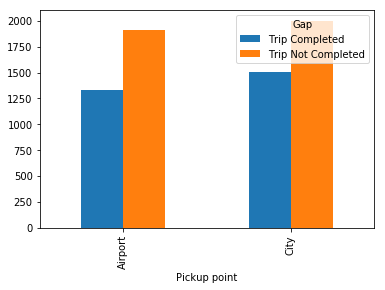

In [28]:
#Plot to count the number of requests that was completed and which was not, against pickup point
gap_pickup_df = pd.DataFrame(uberReq.groupby(['Pickup point','Gap'])['Request id'].count().unstack(fill_value=0))
gap_pickup_df.plot.bar()

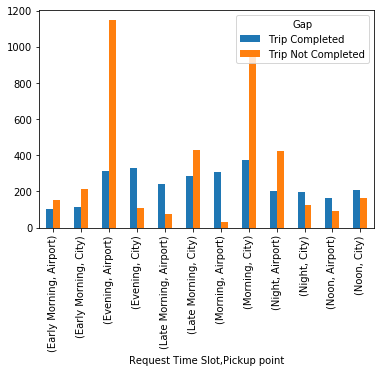

In [29]:
#Plot to count the number of requests that was completed and which was not, for the final analysis
gap_main_df = pd.DataFrame(uberReq.groupby(['Request Time Slot','Pickup point','Gap'])['Request id'].count().unstack(fill_value=0))
gap_main_df.plot.bar()

### Hypothesis :

#### Pickup Point - City :

As per the analysis, the morning time slot is most problematic where the requests are being cancelled. Most probably the requests are being cancelled by the drivers due to the morning rush as it being the office hours and seeing the destination as airport which would be too far, the driver would think to earn more for the shorter trips within the city.

#### Pickup Point - Airport :

Upon analysis, the evening time slot seems to be most problematic for pickup points as airport where the requests being No Cars Available. The reason seems to be that not enough cars are available to service the requests as cars might not be available at the airport due to the cars serving inside the city.

### Conclusions :

- Based on the data analysis performed, following recommendation can be used by Uber to bridge the gap between supply and demand: -

    - For bridging the demand supply gap from airport to city, making a permanent stand in the airport itself where the cabs will be available at all times and the incomplete requests can come down significantly.
    - Uber can provide some incentives to the driver who complete the trip from city to airport in the morning part. This might result the driver to not cancel the request from city to airport trips.
    - Last but sure solution to bring down the gap is to increase the numbers of cab in its fleet.